In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import os.path as osp

import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import NeighborLoader
import torch_geometric.transforms as T

/opt/conda/envs/FDL/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_all = pd.read_csv('./data/raw/data_air.csv')  
df = df_all[df_all['Block Name']=='internalMesh'].iloc[::2]
df.head()

,Block Name,Point ID,Points_0,Points_1,Points_2,Points_Magnitude,T,U_0,U_1,U_2,U_Magnitude,alphat,epsilon,k,nut,p,p_rgh,rho
0,internalMesh,0,-0.01790,-0.1,-0.1,0.142550,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583
2,internalMesh,2,-0.01074,-0.1,-0.1,0.141829,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583
4,internalMesh,4,-0.00358,-0.1,-0.1,0.141467,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583
6,internalMesh,6,0.00358,-0.1,-0.1,0.141467,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583
8,internalMesh,8,0.01074,-0.1,-0.1,0.141829,298.15,0.0,0.1375,0.0,0.1375,0.052486,1.25853,0.099636,0.04502,100001.0,100000.0,1.16583


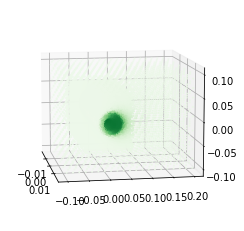

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(elev=10., azim=-10)
ax.scatter3D(df['Points_0'], df['Points_1'], df['Points_2'],c=df['T'], s = 1,cmap='Greens');
#ax.scatter3D(df['Points_0'][0:20], df['Points_1'][0:20], df['Points_2'][0:20], c=df['initial_T'][0:20], s = 10);
#ax.scatter3D(df['Points_0'][0], df['Points_1'][0], df['Points_2'][0], c=df['Points_2'][0], s = 50);
#ax.scatter3D(df['Points_0'][1], df['Points_1'][1], df['Points_2'][1], c=df['Points_2'][1], s = 50);
#ax.scatter3D(df['Points_0'][11], df['Points_1'][11], df['Points_2'][11], c=df['Points_2'][11], s = 50);

In [4]:
class CFD_dataset(Dataset):
    def __init__(self, root, local_neighborhood = 0.01, transform=None, pre_filter=None, train_frac=0.8):
        self.pre_transform=T.RadiusGraph(local_neighborhood)
        self.root = root
        self.train_frac = train_frac
        super().__init__(root, transform, self.pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return ['data_air.csv']

    @property
    def processed_file_names(self):
        return ['data_air.pt']

    def process(self):
        torch.manual_seed(0)
        for idx, raw_path in enumerate(self.raw_paths):
            df = pd.read_csv(raw_path) [df_all['Block Name']=='internalMesh'].iloc[::2]
            x = torch.Tensor(df[['Points_0','Points_1','Points_2']].to_numpy())
            y = torch.Tensor(df[['T']].to_numpy())
            pos = torch.Tensor(df[['Points_0','Points_1','Points_2']].to_numpy())
            data = Data(x = x, edge_index = None, pos = pos, y = y)
            data = self.pre_transform(data)
            # set training mask
            data.train_mask = torch.rand(data.num_nodes) < self.train_frac
            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [5]:
dataset = CFD_dataset('./data/')
dataset.out_features = 1
data = dataset[0]

Processing...
Done!


In [6]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[4]*6,
    batch_size=128,
    input_nodes=data.train_mask,
)
test_loader = NeighborLoader(
    data,
    num_neighbors=[4]*6,
    batch_size=128,
    shuffle=False,
    input_nodes=~data.train_mask,
)


In [7]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=128, hidden_layers=3):
        super().__init__()
        self.layers = [GCNConv(data.num_features, hidden_channels, cached=False)]
        for _ in range(hidden_layers - 1):
            self.layers.append(GCNConv(hidden_channels, hidden_channels, cached=False))
        self.layers = torch.nn.ModuleList(self.layers)
        
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_channels, 1),
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
        x = self.regressor(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = GCN(256, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=5e-4)

In [10]:
# useful function for computing accuracy
import torch.nn as nn
loss_mse = nn.MSELoss()
def compute_mse(pred_y, y):
    return loss_mse(pred_y,y)

In [11]:
from tqdm import trange
# train the model
model.train()
losses_train = []
losses_val = []

EPOCHS = 100
pbar = trange(len(train_loader) * EPOCHS, desc='Training')
for epoch in range(EPOCHS):
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_mse(out, data.y)
        losses_train.append(loss.item())
        loss.backward()
        optimizer.step()
        # validation step
        if i % 20 == 0:
            model.eval()
            with torch.no_grad():
                for data in test_loader:
                    data = data.to(device)
                    out = model(data)
                    loss_val = compute_mse(out, data.y)
                    losses_val.append(loss_val.item())
            model.train()

        pbar.update(1)
        pbar.set_description(f'Epoch {epoch + 1:03d}| Loss train: {loss.item():.4f}, Loss val: {loss_val.item():.4f}')


Epoch 034| Loss: 1.2862:  33%|███▎      | 19886/59700 [11:49<22:14, 29.83it/s]  

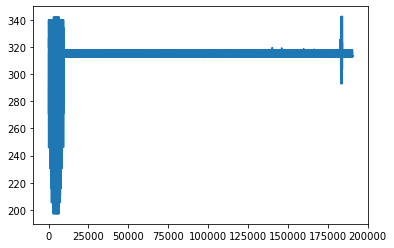

In [ ]:
plt.plot(out.detach().numpy())

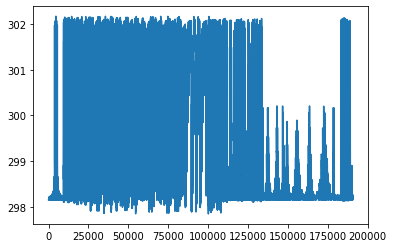

In [ ]:
plt.plot(data.y.detach().numpy())